In [ ]:
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
data = pd.read_csv('dataset_NN.csv')

In [ ]:
#Vectorize Y into one hot encoding
def vector(Y):
    yk = np.zeros((len(Y), np.unique(Y).shape[0]))
    for x in range(len(Y)):
        yk[x, int(Y[x,0]-1)] = 1
    
    return yk


def split_and_vectorize(data):

    #Dataframe to numpy array
    data = data.to_numpy()
    for k in range(len(np.unique(data[:,data.shape[1]-1]))):
        #Unique indexes to sample
        index = random.sample(range(200), 60)
        index = np.array(index)

        #Sampling indexes for training set
        temp = data[index + k*200]

        if k == 0:
            df_test = temp

            #List of indexes sampled
            in_ls = index

        else:
            df_test = np.concatenate([df_test,temp], axis = 0)
            in_ls = np.concatenate([in_ls, index + k*200])

    #Deleting the sampled rows which was used to generate test set thereby we get training set
    df_train = np.delete(data,in_ls,0)

    #Shuffling Training and test set
    np.random.shuffle(df_train)
    np.random.shuffle(df_test)


    #Attributes and Labels split
    X_train = df_train[:, :6]
    Y_train = df_train[:, 6]
    Y_train = Y_train.reshape(len(Y_train), 1)
    Y_train = vector(Y_train)

    X_test = df_test[:, :6]
    Y_test = df_test[:, 6]
    Y_test = Y_test.reshape(len(Y_test), 1)
    #Mean and std along all rows
    mean_tr = X_train.mean(axis = 0)
    std_tr = X_train.std(axis = 0)

    mean_tes = X_test.mean(axis = 0)
    std_tes = X_test.std(axis = 0)

    #Normalization by subtracting by mean and dividing by standard deviation on only real attributes (other features are m-ary)
    X_train[:, 3:6] =  (X_train[:, 3:6] - mean_tr[3:6])/std_tr[3:6]
    X_test[:, 3:6] =  (X_test[:, 3:6] - mean_tes[3:6])/std_tes[3:6]

    return X_train, Y_train, X_test, Y_test




In [ ]:
x_t, y_t, x_te, y_te = split_and_vectorize(data)

In [ ]:
class NN:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.weights = {}
        self.activation = []
        return

    #Activation function and their derivatives.
    def sigmoid(self,Z):
        A = 1/(1+np.exp(-Z))
        return A,Z

    def relu(self,Z):
        A = np.maximum(0,Z)
        return A,Z

    def tanh(self,Z):
        A = np.tanh(Z)
        return A,Z

    #Softmax used at the end node to make probabilistic output with sum of output of all neurons adding to '1'
    def softmax(self,Z):
        A = np.exp(Z)
        A = A/np.sum(A, axis = 0)
        return A, Z

    def leaky_relu(self,Z):
        Z[Z < 0] = 0.01*Z[Z < 0]
        A = Z
        return A,Z

    def sigmoid_der(self,dA, cache):
        Z = cache
    
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)

        return dZ

    def relu_der(self, dA, cache):
        Z = cache
    
        dZ = np.array(dA, copy=True) 
        dZ[dZ <= 0] = 0
    
        return dZ

    def tanh_der(self, dA, cache):
        Z = cache
        t, k = self.tanh(Z)
        dZ = dA * (1 - np.square(k))

        return dZ
    
    def leaky_relu_der(self, dA, cache):
        Z = cache
        dA = Z
        dA[dA < 0] = 0.01
        dA[dA >= 0] = 1 
        
        dZ = dA * Z

        return dZ

    def softmax_der(self, dA, cache):
        Z = cache
        t,k = self.softmax(Z)
        dZ =  dA * (t - np.square(t))
        return dZ
    
    #Initializing the weights of depending upon the dimensions specified by the user
    #returns a dictionary of weights
    def initialize(self,neuron_num):
        weights = {}
        for i in range(1, len(neuron_num)):
            np.random.seed(1)
            weights['W' + str(i)] = np.random.randn(neuron_num[i], neuron_num[i-1])
            weights['b' + str(i)] = np.zeros((neuron_num[i], 1))

        return weights

    #Linear multiplication before applying activation function 
    #Multiplication is Z = W.A + b upon which later activation function is applied
    def mul(self, A, W, b):
        Z = np.matmul(W,A) + b
        cache  = (A, W, b)
        return Z, cache
    #Applying activation function to the output
    #Lin_cache stores the variable A_prev (output of previous layer), W, b (Weights of current layer)
    #Activ_cache stores the output of current layer Z = f(W.A_prev + b) where f is the activation function of the current layer
    def activation_forw(self, A_prev, W, b, activation):
        if activation == 'sigmoid':
            Z, lin_cache = self.mul(A_prev, W, b)
            A, activ_cache = self.sigmoid(Z)
        elif activation == 'tanh':
            Z, lin_cache = self.mul(A_prev, W, b)
            A, activ_cache = self.tanh(Z)
        elif activation == 'relu':
            Z, lin_cache = self.mul(A_prev, W, b)
            A, activ_cache = self.relu(Z)
        elif activation == 'leaky_relu':
            Z, lin_cache = self.mul(A_prev, W, b)
            A, activ_cache = self.leaky_relu(Z)
        elif activation == 'softmax':
            Z, lin_cache = self.mul(A_prev, W, b)
            A, activ_cache = self.softmax(Z)
        
        cache = (lin_cache, activ_cache)
        
        return A, cache
    
    #Forward propagation step where the output of each hidden layer and final output layer is calculated and stored
    def forw_prop(self, X, weights, activation):
        caches = []
        A = X.T
        l = len(activation)
        for i in range(1, l+1):
            A_prev = A
            A, cache = self.activation_forw(A_prev, weights['W'+str(i)], weights['b' + str(i)], activation[i-1])
            caches.append(cache)
        
        return A, caches
    
    #Cost/ Cross-Entropy function of the Multiclass neural network
    def cost(self, Y_cap, Y):
        n = Y_cap.shape[1]
        Y = Y.reshape(Y_cap.shape)
        error = -(1/n)*(np.sum(Y*(np.log(Y_cap))))

        return error

    #Linear derivatives of weights and activation
    def lin_back(self, dZ, cache):
        A_prev, W, b = cache
        n = A_prev.shape[1]
        dW = (1/n) * np.matmul(dZ, A_prev.T) 
        db = (1/n) * np.sum(dZ, axis = 1, keepdims=True)
        dA_prev = np.matmul(W.T, dZ)

        return dA_prev, dW, db

    #Derivatives of activation functions performed by using the stored value in lin_cache and activ_cache
    def activ_back(self, dA, cache, activation):
        lin_cache, activ_cache = cache

        if activation == 'sigmoid':
            dZ = self.sigmoid_der(dA, activ_cache)
            dA_prev, dW, db = self.lin_back(dZ, lin_cache)

        elif activation == 'tanh':
            dZ = self.tanh_der(dA, activ_cache)
            dA_prev, dW, db = self.lin_back(dZ, lin_cache)
        
        elif activation == 'relu':
            dZ = self.relu_der(dA, activ_cache)
            dA_prev, dW, db = self.lin_back(dZ, lin_cache)

        elif activation == 'leaky_relu':
            dZ = self.leaky_relu_der(dA, activ_cache)
            dA_prev, dW, db = self.lin_back(dZ, lin_cache)
        
        elif activation == 'softmax':
            dZ = self.softmax_der(dA, activ_cache)
            dA_prev, dW, db = self.lin_back(dZ, lin_cache)

        return dA_prev, dW, db


    #Backpropagation step where gradients/derivatives of each weight of layer and acitvation is calculated returned as a dictionary
    def back_prop(self, Y_cap, Y, caches, activation):
        grads = {}
        l = len(caches)
        n = Y_cap.shape[1]
        Y = Y.reshape(Y_cap.shape)

        dA =  -(np.divide(Y, Y_cap))
        cr_cache = caches[l-1]
        grads["dA"+str(l-1)], grads["dW"+str(l)], grads["db"+str(l)] = self.activ_back(dA, cr_cache, activation[l-1])

        for i in reversed(range(l-1)):
            cr_cache = caches[i]
            grads["dA"+str(i)], grads["dW"+str(i+1)], grads["db"+str(i+1)] = self.activ_back(grads["dA"+str(i+1)], cr_cache, activation[i])

        return grads

    #Updating the weights w.r.t the learning rate provided by the user
    def update_weights(self, weights, grads, learning_rate):

        n = int(len(weights)/2)
        for i in range(n):
            weights['W'+str(i+1)] = weights['W'+str(i+1)] - learning_rate*grads['dW' + str(i+1)]
            weights['b'+str(i+1)] = weights['b'+str(i+1)] - learning_rate*grads['db' + str(i+1)]

        return weights

    #Training the Neural Network on the given data. Returns cost after every 50 iterations    
    def train(self, learning_rate, activation, neuron_num , batch_size, n_iter):
        costs = []
        neuron_num.insert(0,self.X_train.shape[1])
        neuron_num.append(self.Y_train.shape[1])
        print(neuron_num)
        acc = []
        activation.append('softmax')
        self.activation = activation
        weights = self.initialize(neuron_num)
        self.weights = {}
        n = self.X_train.shape[0]


        for i in range(n_iter):
            str_add = (i*batch_size)%n
            fin_add = (str_add + batch_size)%n
            if fin_add == 0 or str_add > fin_add:
                fin_add = n
            

            Y_cap, caches = self.forw_prop(self.X_train[str_add:fin_add,:], weights, activation)

            temp = self.cost(Y_cap, self.Y_train[str_add:fin_add])

            grads = self.back_prop(Y_cap, self.Y_train[str_add:fin_add], caches, activation)

            weights = self.update_weights(weights, grads, learning_rate)

            self.weights = weights
            costs.append(temp)
            acc.append(self.predict(self.X_test, self.Y_test))
            if i%25 == 0:
                print("Cost after " + str(i) +"th iteration is: " + str(temp) )
            

        return weights, costs, acc

    def predict(self, X_test, Y_test):
        Y_cap, t = self.forw_prop(X_test, self.weights, self.activation)
        Y_cap = Y_cap.T
        Y_k = np.argmax(Y_cap, axis = 1).reshape(Y_cap.shape[0],1)
        Y_k = Y_k + 1
        ac = (Y_k == Y_test)*1
        tp = np.sum(ac)
        accuracy  = tp/len(ac)
        print("Accuracy of the given network is: " + str(accuracy*100)+ "%")
        

        return accuracy*100

    #Relevant plots of cost
    def plots(self, costs, acc):
        k = len(costs)
        x =  np.arange(k)+1   

        plt.subplot(2,1,1)
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(x, costs, 'r-')
        plt.title("Cost per iteration")

        plt.subplot(2,1,2)
        plt.xlabel("Iteration")
        plt.ylabel("Accuracy")
        plt.plot(x, acc, '-.')
        plt.title("Accuracy per iteration")


        plt.show()

        return


            

    

In [ ]:
n = NN(x_t, y_t, x_te, y_te)

In [ ]:
w, c, a = n.train(0.02, ['relu'], [10], 200, 1000)

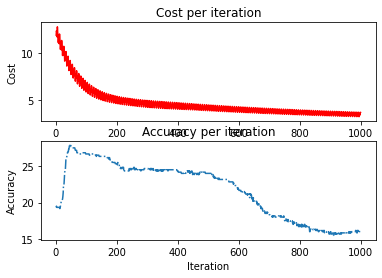

In [ ]:
n.plots(c,a) 